In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import Optional
from tqdm import tqdm
import json

from sentence_transformers import SentenceTransformer  # For sentence embeddings
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter


PROCESSED_FOLDER = '/Users/jing/Documents/RaShips/revelio_matching/Processed'
OUTPUT_FOLDER = '/Users/jing/Documents/RaShips/revelio_matching/alex_outputs'

In [8]:
raw_pitchbook_data = pd.read_csv('/Users/jing/Documents/RaShips/revelio_matching/Data/Pitchbook/Company_sample.csv').drop('Unnamed: 0', axis = 1)
print(raw_pitchbook_data.shape)
raw_pitchbook_data.head()

/var/folders/77/3w18kg3x0d18_zdpyxkjgqdc0000gn/T/ipykernel_46687/3095071482.py:1: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_pitchbook_data = pd.read_csv('/Users/jing/Documents/RaShips/revelio_matching/Data/Pitchbook/Company_sample.csv').drop('Unnamed: 0', axis = 1)


(100000, 121)


,CompanyID,CompanyName,CompanyAlsoKnownAs,CompanyFormerName,CompanyLegalName,Description,Keywords,CompanyFinancingStatus,CompanyFinancingStatusDate,TotalRaised,...,TwitterFollowersPercentChange,MarketInformation,AppMobileReviews,AppGrowthRate,AppGrowthPercentile,AppSizeMultiple,AppSizePercentile,ProfileDataSource,PitchBookProfileLink,LastUpdated
0,279991-81,Natalist,NaN,NaN,Baby Someday Inc.,Manufacturer of fertility care essentials inte...,"fertility business, fertility care, fertility ...",Formerly VC-backed,10/21/2021,5.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PitchBook Research,https://my.pitchbook.com?c=279991-81,11/28/2022
1,459386-83,Audry,NaN,NaN,Audry GmbH,Operator of a media marketplace intended to di...,"media marketplace, podcast community, podcast ...",Venture Capital-Backed,10/04/2020,NaN,...,-0.55,NaN,NaN,NaN,NaN,NaN,NaN,PitchBook Research,https://my.pitchbook.com?c=459386-83,12/10/2022
2,93189-88,InkaBinka,NaN,NaN,"InkaBinka, Inc.",Developer of Web browsing tool designed to ena...,"internet history viewing, mobile media, social...",Formerly VC-backed,01/01/2018,0.275000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PitchBook Research,https://my.pitchbook.com?c=93189-88,10/22/2022
3,432705-61,Variety Space,VarietySpace,NaN,Variety Space (Beijing) Network Technology Co....,Provider of home renovation and home design se...,"home design, home renovation, home renovation ...",Venture Capital-Backed,04/26/2018,12.464087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PitchBook Research,https://my.pitchbook.com?c=432705-61,12/08/2022
4,123997-69,11.TT,NaN,NaN,NaN,Provider of an online sports updates discovery...,"football updates, match-updates discovery plat...",Formerly Accelerator/Incubator backed,11/01/2014,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PitchBook Research,https://my.pitchbook.com?c=123997-69,10/19/2022


In [9]:
for col in raw_pitchbook_data.columns:
    print(col)

CompanyID
CompanyName
CompanyAlsoKnownAs
CompanyFormerName
CompanyLegalName
Description
Keywords
CompanyFinancingStatus
CompanyFinancingStatusDate
TotalRaised
BusinessStatus
BusinessStatusDate
OwnershipStatus
OwnershipStatusDate
Universe
Website
Employees
Exchange
Ticker
YearFounded
ParentCompany
ParentCompanyID
FinancingStatusNote
CikCode
PrimaryIndustrySector
PrimaryIndustryGroup
PrimaryIndustryCode
HQLocation
HQAddressLine1
HQAddressLine2
HQCity
HQState_Province
HQPostCode
HQCountry
HQPhone
HQFax
HQEmail
HQGlobalRegion
HQGlobalSubRegion
AlternateOfficeCount
PrimaryContactPBId
PrimaryContact
PrimaryContactTitle
PrimaryContactEmail
PrimaryContactPhone
ActiveInvestors
FormerInvestors
Revenue
GrossProfit
NetIncome
EnterpriseValue
EBITDA
EBIT
NetDebt
FiscalPeriod
FirstFinancingDealID
FirstFinancingDate
FirstFinancingSize
FirstFinancingSizeStatus
FirstFinancingValuation
FirstFinancingValuationStatus
FirstFinancingDealType
FirstFinancingDealType2
FirstFinancingDealType3
FirstFinancingDealC

In [10]:
first_parquet = pd.read_parquet('/Users/jing/Documents/RaShips/revelio_matching/Data/Revelio/company_ref/company_ref_0000_part_00.parquet')
print(first_parquet.shape)
first_parquet.head()

(289430, 20)


,rcid,company,primary_name,factset_entity_id,year_founded,ticker,exchange_name,sedol,isin,cusip,url,naics_code,cik,lei,linkedin_url,child_rcid,child_company,child_linkedin_url,ultimate_parent_rcid,ultimate_parent_rcid_name
0,6097747,Secretaria De Turismo Esporte E Lazer,Secretaria De Turismo Esporte E Lazer,None,NaN,None,None,None,None,None,turismoesporte.rj.gov.br,None,None,None,http://linkedin.com/company/secretaria-de-turi...,6097747,Secretaria De Turismo Esporte E Lazer,http://linkedin.com/company/secretaria-de-turi...,6097747,Secretaria De Turismo Esporte E Lazer
1,19780503,Urban Environmental Asbestos Abatement,Urban Environmental Asbestos Abatement,None,2008.0,None,None,None,None,None,urbanenvironmental.ca,None,None,None,http://linkedin.com/company/urban-environmenta...,19780503,Urban Environmental Asbestos Abatement,http://linkedin.com/company/urban-environmenta...,19780503,Urban Environmental Asbestos Abatement
2,10733590,Confortshop,Confortshop,None,2010.0,None,None,None,None,None,confortshop.es,None,None,None,http://linkedin.com/company/confortshop,10733590,Confortshop,http://linkedin.com/company/confortshop,10733590,Confortshop
3,19591316,Trishul Concrete Products Limited,Trishul Concrete Products Limited,None,NaN,None,None,None,None,None,None,None,None,None,http://linkedin.com/company/trishul-concrete-p...,19591316,Trishul Concrete Products Limited,http://linkedin.com/company/trishul-concrete-p...,19591316,Trishul Concrete Products Limited
4,8156917,1917 Corp,1917 Corp,None,NaN,None,None,None,None,None,1917corp.com,None,None,None,http://linkedin.com/company/1917-corp-ltd,8156917,1917 Corp,http://linkedin.com/company/1917-corp-ltd,8156917,1917 Corp


In [11]:
for col in first_parquet.columns:
    print(col)

rcid
company
primary_name
factset_entity_id
year_founded
ticker
exchange_name
sedol
isin
cusip
url
naics_code
cik
lei
linkedin_url
child_rcid
child_company
child_linkedin_url
ultimate_parent_rcid
ultimate_parent_rcid_name


In [12]:
processed_files = os.listdir(PROCESSED_FOLDER)
processed_files

['all_positions_matched_pitchbook_multi_method.parquet',
 'pitchbook_company_cleaned.parquet',
 'individual_position_0126_part_01_with_company_cleaned.parquet',
 'individual_position_0130_part_02_with_company_cleaned.parquet',
 'all_positions_matched_pitchbook_multi_method.csv',
 'individual_position_0131_part_02_with_company_cleaned.parquet',
 'individual_position_0126_part_02_with_company_cleaned.parquet',
 'individual_position_0128_part_02_with_company_cleaned.parquet',
 'individual_position_0129_part_02_with_company_cleaned.parquet',
 'individual_position_0126_part_01_with_company_cleaned.csv']

In [88]:
cleaned_pitchbook = pd.read_parquet(f'{PROCESSED_FOLDER}/pitchbook_company_cleaned.parquet')
print(cleaned_pitchbook.shape)
cleaned_pitchbook.head()

(306218, 11)


,companyid,companyname,companyalsoknownas,companylegalname,companyformername,companyname_cleaned,companyalsoknownas_cleaned,companylegalname_cleaned,companyformername_cleaned,hqcountry,hqstate_province
0,10010-89,Broadcom (Acquired 2016),None,Broadcom Corp.,None,broadcom acquired 2016,None,broadcom,None,United States,California
1,56719-45,MDxHealth,None,MDxHealth SA,OncoMethylome Sciences,mdxhealth,None,mdxhealth,oncomethylome sciences,United States,California
2,10022-68,Boart Longyear,None,Boart Longyear Ltd.,None,boart longyear,None,boart longyear,None,United States,Utah
3,56719-63,CMOSIS,None,CMOSIS BVBA,None,cmosis,None,cmosis bvba,None,Belgium,None
4,10024-21,CapitalSource,CSE,"CapitalSource, Inc.",None,capitalsource,cse,capitalsource,None,United States,Maryland


In [89]:
for col in cleaned_pitchbook.columns:
    print(col)

companyid
companyname
companyalsoknownas
companylegalname
companyformername
companyname_cleaned
companyalsoknownas_cleaned
companylegalname_cleaned
companyformername_cleaned
hqcountry
hqstate_province


In [15]:
first_cleaned_revelio = pd.read_parquet(f'{PROCESSED_FOLDER}/individual_position_0126_part_01_with_company_cleaned.parquet')
first_cleaned_revelio.head()

,rcid,company_name,company_raw,company_cleaned,location_raw,region,country,state,metro_area,country_standardized,...,ticker,cusip,naics_code,isin,linkedin_headquarters,gvkey,company_name_cleaned,country_std,linkedin_headquarters_std,state_std
0,7546153.0,State of Alabama,State of Alabama,state of alabama,"Tuscaloosa, Alabama, United States",Northern America,United States,Alabama,alabama nonmetropolitan area,United States,...,None,None,921140,None,None,None,state of alabama,United States,None,AL
1,621897.0,"Graj + Gustavsen, Inc.",Graj + Gustavsen Inc. (G+G),graj gustavsen inc g g,"New York, NY",Northern America,United States,New York,new york city metropolitan area,United States,...,None,None,None,None,"New York, NY",None,graj gustavsen,United States,None,NY
2,94252110.0,Sedgwick Pte Ltd.,Sedgwick CMS,sedgwick cms,"Long Beach, CA",Northern America,United States,California,long beach metropolitan area,United States,...,None,None,None,None,None,None,sedgwick,United States,None,CA
3,92775724.0,Tajmac ZPS AS,TAJMAC-ZPS,tajmac zps,"Indianapolis, Indiana",Northern America,United States,Indiana,indianapolis metropolitan area,United States,...,None,None,333517,None,"Zlín-Malenovice, Zlínský",None,tajmac zps,United States,None,IN
4,409874.0,"Cencora, Inc.",amerisourcebergen,amerisourcebergen,"Knightdale, North Carolina, United States",Northern America,United States,North Carolina,raleigh metropolitan area,United States,...,COR,03073E105,424210,US03073E1055,"Conshohocken, PA",31673,cencora,United States,Panama,NC


In [45]:
all_cleaned_revelio = pd.DataFrame()

for file in processed_files:

    if "individual_position" in file:

        if 'csv' in file:
            cleaned_file = pd.read_csv(f'{PROCESSED_FOLDER}/{file}')
        elif ".parquet" in file:
            cleaned_file = pd.read_parquet(f'{PROCESSED_FOLDER}/{file}')

        all_cleaned_revelio = pd.concat([all_cleaned_revelio, cleaned_file])
        del cleaned_file

all_cleaned_revelio.drop_duplicates(inplace=True)
all_cleaned_revelio.reset_index(drop=True, inplace=True)

In [17]:
for col in first_cleaned_revelio.columns:
    print(col)

rcid
company_name
company_raw
company_cleaned
location_raw
region
country
state
metro_area
country_standardized
state_standardized
company
linkedin_url
url
cik
ticker
cusip
naics_code
isin
linkedin_headquarters
gvkey
company_name_cleaned
country_std
linkedin_headquarters_std
state_std


In [18]:
all_cleaned_revelio.loc[:, ['location_raw', 'linkedin_headquarters', 'country', 'state', 'region', 'metro_area']]

,location_raw,linkedin_headquarters,country,state,region,metro_area
0,"Tuscaloosa, Alabama, United States",None,United States,Alabama,Northern America,alabama nonmetropolitan area
1,"New York, NY","New York, NY",United States,New York,Northern America,new york city metropolitan area
2,"Long Beach, CA",None,United States,California,Northern America,long beach metropolitan area
3,"Indianapolis, Indiana","Zlín-Malenovice, Zlínský",United States,Indiana,Northern America,indianapolis metropolitan area
4,"Knightdale, North Carolina, United States","Conshohocken, PA",United States,North Carolina,Northern America,raleigh metropolitan area
...,...,...,...,...,...,...
471717,"Villigen, Aargau, Switzerland","Villigen PSI, Aargau",Switzerland,Aargau,Western Europe,basel metropolitan area
471718,"Chaoyang District, Beijing, PRC.","Sydney, NSW",China,Beijing,Eastern Asia,beijing metropolitan area
471719,"Brest, France","Paris, France",France,Brittany,Western Europe,france nonmetropolitan area
471720,"Toronto, ON","Sumner, WA",Canada,Ontario,Northern America,toronto metropolitan area


In [19]:
cleaned_pitchbook.hqcountry

0         United States
1         United States
2         United States
3               Belgium
4         United States
              ...      
306213           Brazil
306214           Canada
306215            India
306216          Belgium
306217    United States
Name: hqcountry, Length: 306218, dtype: object

In [20]:
current_matches = pd.read_parquet(f'{PROCESSED_FOLDER}/all_positions_matched_pitchbook_multi_method.parquet')
print(current_matches.shape)
current_matches.head()

(1972, 45)


,pos_key_pos,companyid_pb,pb_idx,method,score,src_file,rank,company_raw_pos,company_linkedin_url_pos,company_cleaned_pos,...,website_domain_pos,hqcountry_pb,hqstate_province_pb,country_std_pb,state_std_pb,companyname_pb,companyalsoknownas_pb,companylegalname_pb,companyformername_pb,file
0,individual_position_0126_part_01_with_company....,168491-44,NaN,linkedin,100.0,individual_position_0126_part_01_with_company....,1,Lidl Nederland,linkedin.com/company/lidl-nederland,lidl nederland,...,lidl.nl,Netherlands,None,Netherlands,None,Lidl Nederland,Lidl,Lidl Nederland GmbH,None,individual_position_0126_part_01_with_company....
1,individual_position_0126_part_01_with_company....,10672-48,NaN,website,100.0,individual_position_0126_part_01_with_company....,2,Braxton Advisors,linkedin.com/company/braxton-advisors,braxton advisors,...,None,Spain,None,Spain,None,Enigma Software Productions,Enigma Software,"Enigma Software Productions, S.L.",None,individual_position_0126_part_01_with_company....
2,individual_position_0126_part_01_with_company....,433769-50,NaN,website,100.0,individual_position_0126_part_01_with_company....,2,Avance BPO,linkedin.com/company/avance-bpo,avance bpo,...,None,Colombia,None,Colombia,None,Netcom Service,Netcom,Netcom Service Ltda,None,individual_position_0126_part_01_with_company....
3,individual_position_0126_part_01_with_company....,10810-63,NaN,website,100.0,individual_position_0126_part_01_with_company....,2,RACHANA TELEVISION PRIVATE LIMITED,linkedin.com/company/rachana-television-privat...,rachana television private limited,...,None,India,Andhra Pradesh,India,None,Nipuna Services,Nipuna,Nipuna Services Limited,None,individual_position_0126_part_01_with_company....
4,individual_position_0126_part_01_with_company....,57431-89,NaN,website,100.0,individual_position_0126_part_01_with_company....,2,Canteen Vending Services,linkedin.com/company/canteen-vending-services,canteen vending services,...,None,United States,Pennsylvania,United States,PA,E-Duction,None,"E-Duction, Inc.",MarketMembers.com,individual_position_0126_part_01_with_company....


In [21]:
print(len(set(current_matches.companyid_pb)))
print(len(set(current_matches.rcid_pos)))

746
1905


In [22]:
for col in current_matches.head():
    if 'pos' in col:
        print(col)

pos_key_pos
company_raw_pos
company_linkedin_url_pos
company_cleaned_pos
location_raw_pos
region_pos
country_pos
state_pos
metro_area_pos
weight_pos
rcid_pos
company_name_pos
ultimate_parent_rcid_pos
ultimate_parent_company_name_pos
onet_code_pos
onet_title_pos
ticker_pos
exchange_pos
cusip_pos
naics_code_pos
naics_description_pos
company_pos
linkedin_headquarters_pos
gvkey_pos
country_std_pos
state_std_pos
_first_name_raw_pos
company_norm_pos
linkedin_norm_pos
website_domain_pos


In [23]:
for col in current_matches.head():
    if 'pb' in col:
        print(col)

companyid_pb
pb_idx
hqcountry_pb
hqstate_province_pb
country_std_pb
state_std_pb
companyname_pb
companyalsoknownas_pb
companylegalname_pb
companyformername_pb


In [24]:
current_matches.loc[:, ['hqstate_province_pb',
'country_std_pb',
'state_std_pb',
'hqcountry_pb']]

,hqstate_province_pb,country_std_pb,state_std_pb,hqcountry_pb
0,None,Netherlands,None,Netherlands
1,None,Spain,None,Spain
2,None,Colombia,None,Colombia
3,Andhra Pradesh,India,None,India
4,Pennsylvania,United States,PA,United States
...,...,...,...,...
1967,Andhra Pradesh,India,None,India
1968,None,Indonesia,None,Indonesia
1969,California,United States,CA,United States
1970,None,Mexico,None,Mexico


In [25]:
current_matches.loc[:, ['_first_name_raw_pos','linkedin_norm_pos', 'company_pos', 'company_cleaned_pos', 'company_name_pos', 'linkedin_headquarters_pos', 'state_std_pos', 'country_std_pos', 'country_pos', 'location_raw_pos']]

,_first_name_raw_pos,linkedin_norm_pos,company_pos,company_cleaned_pos,company_name_pos,linkedin_headquarters_pos,state_std_pos,country_std_pos,country_pos,location_raw_pos
0,lidl nederland,http://linkedin.com/company/lidl-nederland,Lidl Nederland GmbH,lidl nederland,Lidl Nederland GmbH,"Huizen, Noord-Holland",None,Netherlands,Netherlands,"Katwijk, South Holland, Netherlands"
1,braxton advisors,http://linkedin.com/company/braxton-advisors,Braxton Advisors,braxton advisors,Braxton Advisors,"Dallas, Texas",None,Spain,Spain,"Barcelone, Catalogne, Espagne"
2,avance bpo,http://linkedin.com/company/avance-bpo,Avance Bpo,avance bpo,Avance Bpo,None,None,Colombia,Colombia,"Bogotá, Distrito Capital, Colombia"
3,rachana television private limited,http://linkedin.com/company/rachana-television...,Rachana Television Private Limited,rachana television private limited,Rachana Television Private Limited,"HYDERABAD, Telangana",None,India,India,"Hyderabad, Telangana, India"
4,canteen vending services,http://linkedin.com/company/canteen-vending-se...,Canteen Vending Services,canteen vending services,Canteen Vending Services,None,PA,United States,United States,"York County, Pennsylvania, United States"
...,...,...,...,...,...,...,...,...,...,...
1967,cisco systems india private limited bangalore,http://linkedin.com/company/cisco-systems-indi...,Cisco Systems Private Limited Bangalore,cisco systems india private limited bangalore,Cisco Systems Private Limited Bangalore,None,None,India,India,"Bengaluru, Karnataka, India"
1968,ayatama energi trisco nusantara,http://linkedin.com/company/ayatama-energi-tri...,Ayatama Energi Trisco Nusantara,ayatama energi trisco nusantara,Ayatama Energi Trisco Nusantara,None,None,Indonesia,Indonesia,"Semarang, Central Java, Indonesia"
1969,reimagine,http://linkedin.com/company/reimagineoc,Rehabilitation Institute of Southern California,reimagine,Rehabilitation Institute of Southern California,"Santa Ana, California",CA,United States,United States,"Orange County, California, United States"
1970,shows,http://linkedin.com/company/showsapp,Shows (18155800),shows,Shows (18155800),"Emeryville, California",None,Mexico,Mexico,"Alfredo V. Bonfil, Quintana Roo, Mexico"


In [33]:
print(cleaned_pitchbook.loc[cleaned_pitchbook.companyid.isin(current_matches.companyid_pb), :].shape)
print(all_cleaned_revelio.loc[all_cleaned_revelio.rcid.isin(current_matches.rcid_pos), :].shape)

(746, 11)
(57374, 31)


In [35]:
all_cleaned_revelio.loc[all_cleaned_revelio.duplicated('rcid'), ['company_raw', 'rcid']]

,company_raw,rcid
224,"Cornell University, Johnson Graduate School of...",743706.0
293,Cisco,1400574.0
441,SENAC Piracicaba,1072684.0
485,McDonald's,826245.0
522,IBM,22142390.0
...,...,...
471717,Paul Scherrer Institut PSI,858370.0
471718,Argyle Hotel Group,2076928.0
471719,Norela,1703498.0
471720,Western Logistics Inc.,1051218.0


In [36]:
all_cleaned_revelio.loc[all_cleaned_revelio.rcid == 1400574.0, :]

,company_raw,company_linkedin_url,company_cleaned,location_raw,region,country,state,metro_area,startdate,enddate,...,ultimate_parent_factset_id,ultimate_parent_factset_name,company,linkedin_headquarters,gvkey,company_name_cleaned,country_std,linkedin_headquarters_std,state_std,Unnamed: 0
213,Cisco,linkedin.com/company/cisco,cisco,Mexico DF,Central America and the Caribbean,Mexico,empty,mexico nonmetropolitan area,2013-08-01,2016-06-01,...,000DS6-E,CISCO SYSTEMS INC,"Cisco Systems, Inc.","San Jose, CA",20779,cisco systems,Mexico,Canada,None,NaN
293,Cisco,None,cisco,"Amsterdam, Netherlands",Western Europe,Netherlands,North Holland,amsterdam metropolitan area,2007-10-01,2011-03-01,...,000DS6-E,CISCO SYSTEMS INC,"Cisco Systems, Inc.","San Jose, CA",20779,cisco systems,Netherlands,Canada,None,NaN
1392,Cisco Systems,linkedin.com/company/cisco,cisco systems,"Shanghai City, China",Eastern Asia,China,Shanghai,shanghai metropolitan area,2011-08-01,2015-03-01,...,000DS6-E,CISCO SYSTEMS INC,"Cisco Systems, Inc.","San Jose, CA",20779,cisco systems,China,Canada,None,NaN
1660,Cisco,linkedin.com/company/cisco,cisco,"Tokyo, Tokyo, Japan",Eastern Asia,Japan,Tokyo,tokyo metropolitan area,2019-07-01,2023-09-01,...,000DS6-E,CISCO SYSTEMS INC,"Cisco Systems, Inc.","San Jose, CA",20779,cisco systems,Japan,Canada,None,NaN
2187,Cisco,linkedin.com/company/cisco,cisco,San Francisco Bay Area,Northern America,United States,California,san francisco metropolitan area,2016-05-01,2016-08-01,...,000DS6-E,CISCO SYSTEMS INC,"Cisco Systems, Inc.","San Jose, CA",20779,cisco systems,United States,Canada,CA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462777,Cisco,linkedin.com/company/cisco,cisco,"Newcastle upon Tyne, United Kingdom",Northern Europe,United Kingdom,England,newcastle upon tyne metropolitan area,2018-02-01,2019-02-01,...,000DS6-E,CISCO SYSTEMS INC,"Cisco Systems, Inc.","San Jose, CA",20779.0,cisco systems,United Kingdom,Canada,NaN,462777.0
466184,Clarity Wireless,NaN,clarity wireless,"Lake Oswego, Oregon, United States",Northern America,United States,Oregon,portland metropolitan area,1997-01-01,1998-11-01,...,000DS6-E,CISCO SYSTEMS INC,"Cisco Systems, Inc.","San Jose, CA",20779.0,cisco systems,United States,Canada,OR,466184.0
467030,Cisco,linkedin.com/company/cisco,cisco,"Monza and Brianza Area, Italy",Southern Europe,Italy,Lombardy,milan metropolitan area,2017-01-01,2018-07-01,...,000DS6-E,CISCO SYSTEMS INC,"Cisco Systems, Inc.","San Jose, CA",20779.0,cisco systems,Italy,Canada,NaN,467030.0
470152,Cisco,linkedin.com/company/cisco,cisco,"New York, New York, United States",Northern America,United States,New York,new york city metropolitan area,2020-10-01,2021-05-01,...,000DS6-E,CISCO SYSTEMS INC,"Cisco Systems, Inc.","San Jose, CA",20779.0,cisco systems,United States,Canada,NY,470152.0


In [81]:
pos_set = current_matches.loc[:, ['rcid_pos', 'company_cleaned_pos', 'company_raw_pos', 'company_name_pos', 'company_pos']]
pos_set

,rcid_pos,company_cleaned_pos,company_raw_pos,company_name_pos,company_pos
0,1462876.0,lidl nederland,Lidl Nederland,Lidl Nederland GmbH,Lidl Nederland GmbH
1,9836403.0,braxton advisors,Braxton Advisors,Braxton Advisors,Braxton Advisors
2,2192189.0,avance bpo,Avance BPO,Avance Bpo,Avance Bpo
3,5777492.0,rachana television private limited,RACHANA TELEVISION PRIVATE LIMITED,Rachana Television Private Limited,Rachana Television Private Limited
4,20964537.0,canteen vending services,Canteen Vending Services,Canteen Vending Services,Canteen Vending Services
...,...,...,...,...,...
1967,2743447.0,cisco systems india private limited bangalore,"Cisco Systems (India) Private Limited, Bangalore",Cisco Systems Private Limited Bangalore,Cisco Systems Private Limited Bangalore
1968,2210856.0,ayatama energi trisco nusantara,"AYATAMA ENERGI, TRISCO NUSANTARA",Ayatama Energi Trisco Nusantara,Ayatama Energi Trisco Nusantara
1969,7736700.0,reimagine,Reimagine,Rehabilitation Institute of Southern California,Rehabilitation Institute of Southern California
1970,18155800.0,shows,Shows,Shows (18155800),Shows (18155800)


In [37]:
pb_set = current_matches.loc[:, ['companyid_pb', 'companyname_pb', 'hqcountry_pb', 'companyalsoknownas_pb',
'companylegalname_pb',
'companyformername_pb']]
pb_set

,companyid_pb,companyname_pb,hqcountry_pb,companyalsoknownas_pb,companylegalname_pb,companyformername_pb
0,168491-44,Lidl Nederland,Netherlands,Lidl,Lidl Nederland GmbH,None
1,10672-48,Enigma Software Productions,Spain,Enigma Software,"Enigma Software Productions, S.L.",None
2,433769-50,Netcom Service,Colombia,Netcom,Netcom Service Ltda,None
3,10810-63,Nipuna Services,India,Nipuna,Nipuna Services Limited,None
4,57431-89,E-Duction,United States,None,"E-Duction, Inc.",MarketMembers.com
...,...,...,...,...,...,...
1967,10810-63,Nipuna Services,India,Nipuna,Nipuna Services Limited,None
1968,338544-91,Gw id,Indonesia,None,None,None
1969,101969-02,Pillars4Life,United States,Reimagine,"Pillars4Life, Inc.",None
1970,56745-82,Bandtastic,Mexico,None,Crowdfunding México S.A.P.I. de C.V.,None


In [42]:
PB_COLUMNS_MAPPING = {
        "companyid":"companyid",
        "companyname": "Company name:",
        "companylegalname":"Company legal name:",
        "companyalsoknownas" : "Name for which the company is also known:",
        "companyformername" : "Company former name:",
        "website" : "Company website:",
        "ticker" : "Company ticker:",
        "cikcode" : "Company CIK code:",
        "linkedinprofileurl" : "Company Linkedin url:"
        }

POS_COLUMNS_MAPPING = {
        "rcid":"rcid",
        "company_name_cleaned" : "Company name:",
        "company_name" : "Company legal name:",
        "url": "Company website:",
        "ticker" : "Company ticker:",
        "cik": "Company CIK code",
        "linkedin_url": "Company Linkedin url:"
        }

In [43]:
def generate_embedding_inputs(columns_mappings: dict, data: pd.DataFrame) -> list[str]:

    embedding_inputs = []

    for i in range(data.shape[0]):
        embedding_input = ''
        for column, embedding_text in columns_mappings.items():
            if column not in ['rcid', 'companyid']:
                feature_to_insert = data.loc[i, column]
                if pd.notna(feature_to_insert):
                    embedding_input += f'{embedding_text}: {feature_to_insert}, '
        embedding_inputs.append(embedding_input)

    return embedding_inputs

In [46]:
embedding_inputs = []
all_cleaned_revelio.reset_index(drop=True, inplace=True)
data = all_cleaned_revelio
columns_mappings = POS_COLUMNS_MAPPING

for i in range(data.shape[0]):
    embedding_input = ''
    for column, embedding_text in columns_mappings.items():
        feature_to_insert = data.loc[i, column]
        if pd.notna(feature_to_insert):
            embedding_input += f'{embedding_text}: {feature_to_insert}, '
    embedding_inputs.append(embedding_input)

In [47]:
pb_embeddings_inputs = generate_embedding_inputs(columns_mappings=PB_COLUMNS_MAPPING, data=cleaned_pitchbook)[:1000]
pos_embeddings_inputs = generate_embedding_inputs(columns_mappings=POS_COLUMNS_MAPPING, data=all_cleaned_revelio)[:1000]

In [48]:
pos_embeddings_inputs

['Company name:: state of alabama, Company legal name:: State of Alabama, Company website:: alabama.gov, Company Linkedin url:: http://linkedin.com/company/state-of-alabama, ',
 'Company name:: graj gustavsen, Company legal name:: Graj + Gustavsen, Inc., Company website:: ggny.com, Company Linkedin url:: http://linkedin.com/company/graj---gustavsen-inc-g-g, ',
 'Company name:: sedgwick, Company legal name:: Sedgwick Pte Ltd., Company website:: sedgwick.com, Company Linkedin url:: http://linkedin.com/company/sedgwick, ',
 'Company name:: tajmac zps, Company legal name:: Tajmac ZPS AS, Company website:: tajmac-zps.cz, Company Linkedin url:: http://linkedin.com/company/tajmac-zps-a-s-, ',
 'Company name:: cencora, Company legal name:: Cencora, Inc., Company website:: cencora.com, Company ticker:: COR, Company CIK code: 1140859, Company Linkedin url:: http://linkedin.com/company/amerisourcebergen, ',
 'Company name:: gold eye clinic, Company legal name:: Gold Eye Clinic, Company Linkedin u

In [49]:
model = SentenceTransformer(model_name_or_path="all-MiniLM-L6-v2", trust_remote_code=True)
pos_embeddings = model.encode(
            pos_embeddings_inputs,
            convert_to_tensor=False
        )       

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [50]:
pb_embeddings = model.encode(
            pb_embeddings_inputs,
            convert_to_tensor=False
        )  

In [61]:
sim_matrix = cosine_similarity(pos_embeddings, pb_embeddings)

In [62]:
print(len(sim_matrix[sim_matrix != 0]))
sim_matrix

1000000


array([[0.42747748, 0.6045034 , 0.63635474, ..., 0.62630135, 0.42399037,
        0.66526043],
       [0.5066102 , 0.5686803 , 0.58982074, ..., 0.6446005 , 0.48795515,
        0.62630177],
       [0.42406255, 0.6424084 , 0.75337684, ..., 0.80126613, 0.4339881 ,
        0.73529756],
       ...,
       [0.3558198 , 0.6106894 , 0.6931766 , ..., 0.6702582 , 0.3623984 ,
        0.7242657 ],
       [0.2964846 , 0.64826477, 0.59996355, ..., 0.5860975 , 0.43865275,
        0.6949759 ],
       [0.43460783, 0.52241695, 0.5369974 , ..., 0.64601386, 0.45361617,
        0.5853431 ]], dtype=float32)

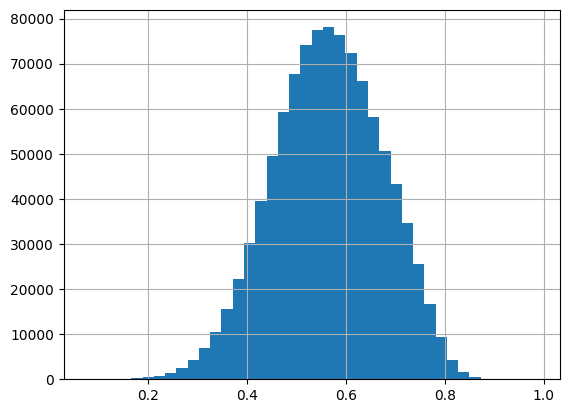

In [63]:
plt.hist(sim_matrix[sim_matrix != 0].flatten(), bins=40)
plt.grid()
plt.show()

In [64]:
np.max(sim_matrix[sim_matrix < 1])

0.98631275

In [66]:
sim_matrix = cosine_similarity(pos_embeddings, pb_embeddings)
matches = dict()
matches['sim_score'] = []
# available_pos_coordinates = np.arange(sim_matrix.shape[0])
# available_pb_coordinates = np.arange(sim_matrix.shape[0])
i = 0
total = 1000

with tqdm(total=total) as p_bar:
    while i < total:
        max_sim_score = sim_matrix[sim_matrix == sim_matrix.max()][0]
        max_coordinates = np.where(sim_matrix == np.max(sim_matrix))
        max_pos_coordinate = max_coordinates[0][0]
        max_pb_coordinate = max_coordinates[1][0]
        for column in POS_COLUMNS_MAPPING.keys():
            col_name = f'{column}_pos'
            if col_name not in matches:
                matches[col_name] = []
            matches[col_name].append(all_cleaned_revelio.loc[max_pos_coordinate, column])
        for column in PB_COLUMNS_MAPPING.keys():
            col_name = f'{column}_pb'
            if col_name not in matches:
                matches[col_name] = []
            matches[col_name].append(cleaned_pitchbook.loc[max_pb_coordinate, column])

        matches['sim_score'].append(max_sim_score)
        # available_pb_coordinates = available_pb_coordinates[available_pb_coordinates != max_pb_coordinate]
        # available_pos_coordinates = available_pos_coordinates[available_pos_coordinates != max_pos_coordinate]
        i += 1
        p_bar.update(1)
        sim_matrix[max_pos_coordinate, :] = 0
        sim_matrix[:, max_pb_coordinate] = 0

lengths = {k: len(v) for k,v in matches.items()}
print("Column lengths:", lengths)


100%|██████████| 1000/1000 [00:02<00:00, 392.79it/s]

Column lengths: {'sim_score': 1000, 'rcid_pos': 1000, 'company_name_cleaned_pos': 1000, 'company_name_pos': 1000, 'url_pos': 1000, 'ticker_pos': 1000, 'cik_pos': 1000, 'linkedin_url_pos': 1000, 'companyid_pb': 1000, 'companyname_pb': 1000, 'companylegalname_pb': 1000, 'companyalsoknownas_pb': 1000, 'companyformername_pb': 1000, 'website_pb': 1000, 'ticker_pb': 1000, 'cikcode_pb': 1000, 'linkedinprofileurl_pb': 1000}


In [67]:
matches_data = pd.DataFrame(matches)
# matches_data = pd.merge(matches_data, cleaned_pitchbook.loc[:, ['companyname', 'companyid']], on = 'companyname', how = 'left')
# matches_data = pd.merge(matches_data, all_cleaned_revelio.loc[:, ['company_name', 'rcid']], on = 'company_name', how = 'left')
# matches_data.loc[:, 'match_id'] = matches_data.apply(lambda x: x['companyid'] + '_' + str(x['rcid']), axis=1)
# matches_data.drop_duplicates(inplace=True)
matches_data

,sim_score,rcid_pos,company_name_cleaned_pos,company_name_pos,url_pos,ticker_pos,cik_pos,linkedin_url_pos,companyid_pb,companyname_pb,companylegalname_pb,companyalsoknownas_pb,companyformername_pb,website_pb,ticker_pb,cikcode_pb,linkedinprofileurl_pb
0,0.986313,803508.0,tesla,"Tesla, Inc.",tesla.com,TSLA,1318605,http://linkedin.com/company/tesla-motors,10377-37,Tesla,"Tesla, Inc.",None,Tesla Motors,www.tesla.com,TSLA,1318605,https://www.linkedin.com/company/tesla-motors
1,0.973179,1311350.0,intel,Intel Corp.,intel.com,INTC,50863,http://linkedin.com/company/intel-corporation,10035-64,Intel,Intel Corporation,None,NM Electronics,www.intel.com,INTC,50863,https://www.linkedin.com/company/intel-corpora...
2,0.947887,967071.0,novartis,Novartis AG,novartis.com,NOVN,1114448,http://linkedin.com/company/novartis,10877-23,Novaled,Novaled AG,None,None,www.novaled.com,None,1543664,https://www.linkedin.com/company/novaled
3,0.928992,580523.0,novocure,NovoCure Ltd.,novocure.com,NVCR,1645113,http://linkedin.com/company/novocure-inc,56920-42,NovoEd,"NovoEd, Inc.",None,None,www.novoed.com,None,1609466,https://www.linkedin.com/company/novoed
4,0.927063,1004191.0,sei investments,SEI Investments Co.,seic.com,SEIC,350894,http://linkedin.com/company/sei,10861-39,SEI Investments,SEI Investments Management Corporation,"SEI, Sei Global Services, Sei Global Services ...",None,www.seic.com,SEIC,350894,https://www.linkedin.com/company/sei
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.260161,409549.0,prince georges county public schools,Prince George's County Public Schools,pgcps.org,None,None,http://linkedin.com/company/pgcps,10327-69,Cambridge Display Technology,Cambridge Display Technology Ltd.,CDT,Cambridge Display Technology Inc.,www.cdtltd.co.uk,None,None,None
996,0.255575,564380.0,clayton county board of education georgia,Clayton County Board of Education (Georgia),clayton.k12.ga.us,None,None,http://linkedin.com/company/ccpsnews,57186-55,Telekinesys Research,Telekinesys Research Limited,Havok,None,www.havok.com,None,None,None
997,0.252254,448531.0,charleston county school district south carolina,Charleston County School District (South Carol...,charleston.com,None,None,http://linkedin.com/company/charleston-county-...,56891-26,Solarlite CSP Technology,Solarlite CSP Technology GmbH,Solarlite,None,www.solarlite.de,None,None,None
998,0.230251,20048258.0,king county school district no 411 washington,King County School District No. 411 (Washington),issaquah.wednet.edu,None,None,http://linkedin.com/company/issaquah-sd,10869-67,Artima,Artima Retail Investment Company S.A.,Artima Retail Investment Company,None,None,None,None,None


In [ ]:
matches_data.loc[matches_data.sim_score >= 0., :]

,sim_score,company_name_cleaned,company_name,companyname,companylegalname
0,1.000000,meta platforms,"Meta Platforms, Inc.",Meta Platforms,"Meta Platforms, Inc."
1,1.000000,fiserv,"Fiserv, Inc.",Fiserv,"Fiserv, Inc."
2,1.000000,paypal holdings,"PayPal Holdings, Inc.",PayPal Holdings,"PayPal Holdings, Inc."
3,1.000000,maxim integrated products,"Maxim Integrated Products, Inc.",Maxim Integrated Products,"Maxim Integrated Products, Inc."
4,1.000000,ulta beauty,"Ulta Beauty, Inc.",ULTA Beauty,"Ulta Beauty, Inc."
5,1.000000,sun microsystems,"Sun Microsystems, Inc.",Sun Microsystems,"Sun Microsystems, Inc."
6,1.000000,tesla,"Tesla, Inc.",Tesla,"Tesla, Inc."
7,0.996405,electronic arts,"Electronic Arts, Inc.",Electronic Arts,Electronic Arts Inc.
8,0.995064,intel,Intel Corp.,Intel,Intel Corporation
9,0.976359,sei investments,SEI Investments Co.,SEI Investments,SEI Investments Management Corporation


In [200]:
current_matches = pd.read_parquet(f'{PROCESSED_FOLDER}/all_positions_matched_pitchbook_multi_method.parquet')
current_matches.loc[:, 'match_id'] = current_matches.apply(lambda x: x['companyid_pb'] + '_' + str(x['rcid_pos']), axis=1)
current_matches_cleaned = current_matches.loc[:, list(matches_data.columns[1:]) + ['method']]
current_matches_cleaned.to_excel(f'{OUTPUT_FOLDER}/current_matches_cleaned.xlsx', index=False)
current_matches_cleaned.head()

,company_cleaned_pos,company_name_pos,companyname_pb,companylegalname_pb,companyid_pb,rcid_pos,match_id,method
0,lidl nederland,Lidl Nederland GmbH,Lidl Nederland,Lidl Nederland GmbH,168491-44,1462876.0,168491-44_1462876.0,linkedin
1,braxton advisors,Braxton Advisors,Enigma Software Productions,"Enigma Software Productions, S.L.",10672-48,9836403.0,10672-48_9836403.0,website
2,avance bpo,Avance Bpo,Netcom Service,Netcom Service Ltda,433769-50,2192189.0,433769-50_2192189.0,website
3,rachana television private limited,Rachana Television Private Limited,Nipuna Services,Nipuna Services Limited,10810-63,5777492.0,10810-63_5777492.0,website
4,canteen vending services,Canteen Vending Services,E-Duction,"E-Duction, Inc.",57431-89,20964537.0,57431-89_20964537.0,website


In [202]:
Counter(current_matches_cleaned.method)

Counter({'website': 1425, 'linkedin': 428, 'fuzzy': 119})

In [178]:
matches_data.match_id.isin(current_matches.match_id).mean()

0.32372619660319096

In [204]:
matches_not_in_current = matches_data.loc[~matches_data.match_id.isin(current_matches.match_id), :]
matches_not_in_current.to_excel(f'{OUTPUT_FOLDER}/embeddings_matches_not_in_current.xlsx', index=False)
matches_not_in_current.head()

,sim_score,company_cleaned_pos,company_name_pos,companyname_pb,companylegalname_pb,companyid_pb,rcid_pos,match_id
384,0.945267,flex,Flex Ltd.,Flexential,Flexential Inc.,12313-45,1444763.0,12313-45_1444763.0
428,0.926162,applied magnetics corp,Applied Magnetics Limited,Magnetic Solutions,Magnetic Solutions Limited,54757-81,93511978.0,54757-81_93511978.0
556,0.867099,pt motasa indonesia,PT Motasa Indonesia,Orori,PT Orori Indonesia,100021-87,7869751.0,100021-87_7869751.0
574,0.855687,precicontact inc,Precicontact,PreEye,PreEye AB,60701-41,16919955.0,60701-41_16919955.0
580,0.850634,interal,Interal (93217772),INTERTREND,"INTERTREND, s.r.o.",57174-49,93217772.0,57174-49_93217772.0


In [205]:
ground_wrong_matches = current_matches_cleaned.loc[~current_matches_cleaned.match_id.isin(matches_data.match_id)]
ground_wrong_matches.to_excel(f'{OUTPUT_FOLDER}/current_matches_not_in_embeddings.xlsx', index=False)
ground_wrong_matches.head()

,company_cleaned_pos,company_name_pos,companyname_pb,companylegalname_pb,companyid_pb,rcid_pos,match_id,method
1,braxton advisors,Braxton Advisors,Enigma Software Productions,"Enigma Software Productions, S.L.",10672-48,9836403.0,10672-48_9836403.0,website
2,avance bpo,Avance Bpo,Netcom Service,Netcom Service Ltda,433769-50,2192189.0,433769-50_2192189.0,website
3,rachana television private limited,Rachana Television Private Limited,Nipuna Services,Nipuna Services Limited,10810-63,5777492.0,10810-63_5777492.0,website
4,canteen vending services,Canteen Vending Services,E-Duction,"E-Duction, Inc.",57431-89,20964537.0,57431-89_20964537.0,website
5,baptist church,Baptist Church,Nipuna Services,Nipuna Services Limited,10810-63,2250694.0,10810-63_2250694.0,website


In [206]:
matches_data.to_excel(f'{OUTPUT_FOLDER}/embedding_matches_13_11.xlsx', index = False)

In [75]:
with open("/Users/jing/Documents/RaShips/revelio_matching/embeddings_files/embeddings_2/embeddings_2_all-MiniLM-L6-v2.json") as file:
    current_embeddings = json.load(file)

print(len(current_embeddings['position']))
print(len(current_embeddings['pitchbook']))

951
1002


In [34]:
print(current_embeddings['pitchbook'].keys())

dict_keys(['length_text', '10010-89', 'memory_GB', '56719-45', '10022-68', '56719-63', '10024-21', '56720-26', '10030-42', '56721-70', '10035-64', '56722-24', '10064-35', '56723-05', '10068-40', '56723-23', '10070-74', '56723-32', '10072-90', '56723-86', '10077-76', '56724-40', '10086-67', '56726-29', '10093-24', '56726-47', '10101-16', '56726-56', '10109-71', '56727-19', '10110-61', '56727-46', '10113-31', '56727-73', '10113-67', '56727-82', '10114-12', '56728-54', '10116-28', '56729-08', '10121-14', '56729-17', '10146-07', '56729-35', '10146-34', '56729-44', '10148-41', '56729-62', '10149-58', '56729-71', '10155-97', '56729-80', '10166-59', '56730-07', '10167-67', '56730-97', '10168-84', '56731-60', '10173-43', '56731-78', '10174-60', '56732-32', '10181-62', '56732-68', '10182-97', '56733-22', '10188-64', '56733-85', '10188-82', '56733-94', '10190-71', '56734-30', '10195-30', '56734-39', '10200-88', '56734-57', '10202-32', '56735-20', '10202-50', '56735-29', '10211-86', '56735-38', '

In [32]:
current_embeddings['position']['7546153.0']

[-0.10857933759689331,
 0.09144800901412964,
 -0.07090727239847183,
 -0.013121276162564754,
 -0.03518758341670036,
 0.037295278161764145,
 0.0006611230783164501,
 -0.026512999087572098,
 0.017617836594581604,
 -0.05519523471593857,
 -0.04758584499359131,
 -0.08603551983833313,
 0.08017826825380325,
 -0.06863341480493546,
 -0.04438508674502373,
 0.011666624806821346,
 0.045123834162950516,
 -0.021904269233345985,
 -0.0573049895465374,
 0.008077781647443771,
 -0.034250542521476746,
 0.14020904898643494,
 -0.020904414355754852,
 -0.013516625389456749,
 -0.010194848291575909,
 -0.010403910651803017,
 0.03139393776655197,
 0.06528104841709137,
 -0.005144068039953709,
 -0.020548595115542412,
 0.1697075217962265,
 0.012966754846274853,
 0.050022996962070465,
 -0.03467240929603577,
 0.11573905497789383,
 -0.0513654388487339,
 -0.028408892452716827,
 -0.019434703513979912,
 0.05295255780220032,
 0.06322528421878815,
 0.004871873650699854,
 -0.01907394267618656,
 0.013996136374771595,
 0.0609951

In [27]:
positions_ids = all_cleaned_revelio.rcid.to_list()

In [28]:
positions_ids

[7546153.0,
 621897.0,
 94252110.0,
 92775724.0,
 409874.0,
 93277135.0,
 923488.0,
 1200304.0,
 1377536.0,
 12965685.0,
 847791.0,
 7740620.0,
 743706.0,
 1303929.0,
 27820656.0,
 946422.0,
 754228.0,
 234540.0,
 6692927.0,
 22145246.0,
 1628352.0,
 899557.0,
 154589.0,
 4916989.0,
 56729.0,
 903784.0,
 22785598.0,
 4366073.0,
 1460222.0,
 72799.0,
 558854.0,
 2652432.0,
 210806.0,
 947133.0,
 29206.0,
 287573.0,
 425987.0,
 185633.0,
 22231807.0,
 6692848.0,
 92885865.0,
 92768321.0,
 1162736.0,
 441182.0,
 903637.0,
 3744964.0,
 286657.0,
 647627.0,
 1006006.0,
 22665834.0,
 1720201.0,
 1165410.0,
 393528.0,
 8090804.0,
 350953.0,
 20923137.0,
 421002.0,
 583855.0,
 7391326.0,
 3025280.0,
 45970.0,
 915339.0,
 726387.0,
 1019691.0,
 799451.0,
 26857266.0,
 1439567.0,
 195590.0,
 315613.0,
 1335912.0,
 506904.0,
 467138.0,
 743706.0,
 267301.0,
 22158132.0,
 1367292.0,
 674.0,
 8591.0,
 358122.0,
 157686.0,
 469205.0,
 475684.0,
 494205.0,
 766564.0,
 15217028.0,
 637344.0,
 829970.0

In [35]:
cleaned_pitchbook

,companyid,companyname,companyalsoknownas,companylegalname,companyformername,companyname_cleaned,companyalsoknownas_cleaned,companylegalname_cleaned,companyformername_cleaned,hqcountry,...,website,exchange,ticker,cikcode,primaryindustrysector,primaryindustrygroup,primaryindustrycode,hqcity,twitterprofileurl,linkedinprofileurl
0,10010-89,Broadcom (Acquired 2016),None,Broadcom Corp.,None,broadcom acquired 2016,None,broadcom,None,United States,...,None,None,None,1054374,Information Technology,Semiconductors,General Purpose Semiconductors,Irvine,None,None
1,56719-45,MDxHealth,None,MDxHealth SA,OncoMethylome Sciences,mdxhealth,None,mdxhealth,oncomethylome sciences,United States,...,www.mdxhealth.com,BRU,MDXH,1872529,Healthcare,Pharmaceuticals and Biotechnology,Biotechnology,Irvine,https://twitter.com/MDxHealth,https://www.linkedin.com/company/mdxhealth
2,10022-68,Boart Longyear,None,Boart Longyear Ltd.,None,boart longyear,None,boart longyear,None,United States,...,www.boartlongyear.com,ASX,BLY,1400561,Energy,Energy Equipment,Oil and Gas Equipment,West Valley City,https://twitter.com/BoartLongyear,https://www.linkedin.com/company/boart-longyear
3,56719-63,CMOSIS,None,CMOSIS BVBA,None,cmosis,None,cmosis bvba,None,Belgium,...,www.cmosis.com,None,None,None,Information Technology,Semiconductors,Application Specific Semiconductors,Antwerp,None,None
4,10024-21,CapitalSource,CSE,"CapitalSource, Inc.",None,capitalsource,cse,capitalsource,None,United States,...,www.capitalsource.com,None,None,1241199,Financial Services,Other Financial Services,Specialized Finance,Chevy Chase,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306213,483340-78,N Sports,NSports,None,None,n sports,nsports,None,None,Brazil,...,www.nsports.com.br,None,None,None,Information Technology,Software,Entertainment Software,Sao Paulo,https://twitter.com/nsports,None
306214,11056-06,Enhance Energy,None,"Enhance Energy, Inc.",None,enhance energy,None,enhance energy,None,Canada,...,www.enhanceenergy.com,None,None,None,Business Products and Services (B2B),Commercial Services,Environmental Services (B2B),Calgary,None,https://www.linkedin.com/company/enhance-energ...
306215,294566-32,Drutha,None,Drutha Software Technologies Pvt Ltd,None,drutha,None,drutha software technologies,None,India,...,www.drutha.com,None,None,None,Information Technology,IT Services,IT Consulting and Outsourcing,Hyderabad,None,https://www.linkedin.com/company/drutha-softwa...
306216,58301-74,PCIM,Dolcea,PCIM S.A.,None,pcim,dolcea,pcim sa,None,Belgium,...,None,None,None,None,Business Products and Services (B2B),Commercial Products,Other Commercial Products,Achene,None,None


In [84]:
second_matches = pd.read_excel("/Users/jing/Documents/RaShips/revelio_matching/embeddings_files/embeddings_2/matches_output/all-MiniLM-L6-v2_matches.xlsx")
print(second_matches.shape)
second_matches.loc[second_matches.sim_score >= 0.8, :]

(100, 17)


,sim_score,rcid_pos,company_name_cleaned_pos,company_name_pos,url_pos,ticker_pos,cik_pos,linkedin_url_pos,companyid_pb,companyname_pb,companylegalname_pb,companyalsoknownas_pb,companyformername_pb,website_pb,ticker_pb,cikcode_pb,linkedinprofileurl_pb
0,0.888333,267301,citigroup,"Citigroup, Inc.",citigroup.com,C,831001.0,http://linkedin.com/company/citi,10113-31,IntraLinks,"IntraLinks, Inc.",NaN,TA Indigo Holding,www.intralinks.com,NaN,1488075,https://www.linkedin.com/company/intralinks
1,0.874021,799451,astatech,"Astatech, Inc.",astatech.com,NaN,NaN,http://linkedin.com/company/astatech-inc-,56727-82,Netline,NetLine Corporation,NaN,NaN,www.netline.com,NaN,NaN,https://www.linkedin.com/company/netline-corpo...
2,0.849627,154589,amedisys,"Amedisys, Inc.",amedisys.com,AMED,896262.0,http://linkedin.com/company/amedisys,10093-24,Ameripath,"Ameripath, Inc.",NaN,NaN,www.ameripath.com,NaN,NaN,https://www.linkedin.com/company/ameripath
3,0.846288,766564,dlf,DLF Ltd.,dlf.in,532868,1622267.0,http://linkedin.com/company/dlf,10022-68,Boart Longyear,Boart Longyear Ltd.,NaN,NaN,www.boartlongyear.com,BLY,1400561,https://www.linkedin.com/company/boart-longyear
4,0.839985,350953,microsoft,Microsoft Corp.,microsoft.com,MSFT,789019.0,http://linkedin.com/company/microsoft,10241-56,NetSpend,Netspend Corporation,NaN,NaN,www.netspend.com,NaN,1496623,https://www.linkedin.com/company/netspend
5,0.837937,22158132,bbdo,BBDO,bbdo.com,NaN,NaN,http://linkedin.com/company/bbdo,56735-20,Expanite,Expanite A/S,NaN,NaN,www.expanite.com,NaN,NaN,https://www.linkedin.com/company/expanite-a-s
6,0.833138,409874,cencora,"Cencora, Inc.",cencora.com,COR,1140859.0,http://linkedin.com/company/amerisourcebergen,56727-19,Celtx,"Celtx, Inc.",NaN,NaN,www.celtx.com,NaN,NaN,https://www.linkedin.com/company/celtx
7,0.832780,27820656,fortrea,"Fortrea, Inc.",fortrea.com,NaN,NaN,http://linkedin.com/company/fortrea,56727-46,FastSpring,"Bright Market, LLC",NaN,NaN,www.fastspring.com,NaN,NaN,https://www.linkedin.com/company/fastspring
8,0.816753,6692927,the specialty,The Specialty Company,tscinc.net,NaN,NaN,http://linkedin.com/company/the-specialty-company,56720-26,Bienca,Bienca S.A.,NaN,NaN,www.bienca.com,NaN,NaN,https://www.linkedin.com/company/bienca-belgium
9,0.802767,22255976,conair,Conair Corp.,conair.com,NaN,769208.0,http://linkedin.com/company/conair-corporation,56729-17,Congatec,Congatec GmbH,NaN,NaN,www.congatec.com,NaN,1648741,https://www.linkedin.com/company/congatec


In [86]:
second_matches = pd.read_excel("/Users/jing/Documents/RaShips/revelio_matching/embeddings_files/embeddings_2/matches_output/all-mpnet-base-v2_matches.xlsx")
print(second_matches.shape)
second_matches

(100, 18)


,sim_score,id_pos,rcid_pos,company_name_cleaned_pos,company_name_pos,url_pos,ticker_pos,cik_pos,linkedin_url_pos,companyid_pb,companyname_pb,companylegalname_pb,companyalsoknownas_pb,companyformername_pb,website_pb,ticker_pb,cikcode_pb,linkedinprofileurl_pb
0,0.807525,22158132.0_74,22158132,bbdo,BBDO,bbdo.com,NaN,NaN,http://linkedin.com/company/bbdo,56735-20,Expanite,Expanite A/S,NaN,NaN,www.expanite.com,NaN,NaN,https://www.linkedin.com/company/expanite-a-s
1,0.785906,92775724.0_3,92775724,tajmac zps,Tajmac ZPS AS,tajmac-zps.cz,NaN,NaN,http://linkedin.com/company/tajmac-zps-a-s-,56735-38,Firmafon,Firmafon ApS,NaN,NaN,www.firmafon.dk,NaN,NaN,https://www.linkedin.com/company/firmafon
2,0.783124,799451.0_64,799451,astatech,"Astatech, Inc.",astatech.com,NaN,NaN,http://linkedin.com/company/astatech-inc-,10113-67,InvestorForce,"Investor Force, Inc.",NaN,NaN,www.investorforce.com,NaN,NaN,NaN
3,0.743850,621897.0_1,621897,graj gustavsen,"Graj + Gustavsen, Inc.",ggny.com,NaN,NaN,http://linkedin.com/company/graj---gustavsen-i...,10182-97,Genscape,"Genscape, Inc.",NaN,NaN,www.genscape.com,NaN,NaN,NaN
4,0.742290,27820656.0_14,27820656,fortrea,"Fortrea, Inc.",fortrea.com,NaN,NaN,http://linkedin.com/company/fortrea,56727-46,FastSpring,"Bright Market, LLC",NaN,NaN,www.fastspring.com,NaN,NaN,https://www.linkedin.com/company/fastspring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.342162,286657.0_46,286657,clark county school district nevada,Clark County School District (Nevada),ccsd.net,NaN,NaN,http://linkedin.com/company/clark-county-schoo...,10114-12,Kurtosys Systems,Kurtosys Systems Inc.,Kurtosys,NaN,www.kurtosys.com,NaN,1376277,https://www.linkedin.com/company/kurtosys
96,0.338778,947133.0_33,947133,occupied renovations,"Occupied Renovations, Inc.",commercialcarpetspecialists.com,NaN,NaN,http://linkedin.com/company/occupied-renovations,56736-28,Pion Imaging Systems,Pion Imaging Systems ApS,Pion,NaN,www.pion.tv,NaN,NaN,NaN
97,0.300760,701075.0_98,701075,the college of westchester,The College of Westchester,cw.edu,NaN,NaN,http://linkedin.com/company/the-college-of-wes...,56727-73,Circuit Semantics,Circuit Semantics Inc.,CSI,NaN,www.circuitsemantics.com,NaN,NaN,NaN
98,0.238907,2652432.0_31,2652432,northwestern university center for talent deve...,Northwestern University Center For Talent Deve...,ctd.northwestern.edu,NaN,NaN,http://linkedin.com/company/center-for-talent-...,10190-71,HDS Cosmetics Lab,HDS Cosmetics Lab Inc.,"DDF, Doctor's Dermatologic Formula",NaN,www.ddfskincare.com,NaN,NaN,NaN


In [78]:
second_matches.loc[second_matches.sim_score >= 0.9, :]

,sim_score,rcid_pos,company_name_cleaned_pos,company_name_pos,companyid_pb,companyname_pb,companylegalname_pb
0,1.000000,1335912,sun microsystems,"Sun Microsystems, Inc.",10596-52,Sun Microsystems,"Sun Microsystems, Inc."
1,1.000000,1221768,fiserv,"Fiserv, Inc.",10235-08,Fiserv,"Fiserv, Inc."
2,1.000000,803508,tesla,"Tesla, Inc.",10377-37,Tesla,"Tesla, Inc."
3,1.000000,1233178,meta platforms,"Meta Platforms, Inc.",10695-52,Meta Platforms,"Meta Platforms, Inc."
4,0.995064,1311350,intel,Intel Corp.,10035-64,Intel,Intel Corporation
5,0.976359,1004191,sei investments,SEI Investments Co.,10861-39,SEI Investments,SEI Investments Management Corporation
6,0.951544,967071,novartis,Novartis AG,10877-23,Novaled,Novaled AG
7,0.905816,583396,first data,First Data Corp.,56874-43,Access Data,Access Data Corp.


In [71]:
sub_cleaned_revelio = all_cleaned_revelio.iloc[:1000, :]
second_matches.loc[~second_matches.rcid_pos.isin(sub_cleaned_revelio.rcid), :]

,sim_score,rcid_pos,company_name_cleaned_pos,company_name_pos,url_pos,ticker_pos,cik_pos,linkedin_url_pos,companyid_pb,companyname_pb,companylegalname_pb,companyalsoknownas_pb,companyformername_pb,website_pb,ticker_pb,cikcode_pb,linkedinprofileurl_pb


In [73]:
sub_cleaned_revelio.loc[sub_cleaned_revelio.rcid.isin(second_matches.isin(second_matches.rcid_pos)), :]

,rcid,company_name,company_raw,company_cleaned,location_raw,region,country,state,metro_area,country_standardized,...,startdate,enddate,ultimate_parent_rcid,ultimate_parent_company_name,onet_code,onet_title,exchange,naics_description,ultimate_parent_factset_id,ultimate_parent_factset_name
